# Rydberg circuits

In addition to the fermionic setting introduced in [the first tutorial](./01_introduction_and_fermionic_circuits.ipynb), the Qiskit cold atom module naturally supports Rydberg hardware, which is the neutral atom implementation of qubits. They are described through the Hamiltonian:

$$
\hat{H}_{ryd} = \Omega \sum_i \sigma_{x,i} + \Delta \sum_i \sigma_{z,i} + \phi \sum_{i\neq j} \frac{\hat{n}_i \hat{n}_j}{|i-j|^6}
$$

The occupation number is defined as $\hat{n}_i = Z_i + \frac{1}{2}$ and the spin operators are $\sigma_{x,i} = \frac{1}{2}X_i$ as well as $\sigma_{z,i} = \frac{1}{2}Z_i$. Here, the unit of information, i.e. the individual wires in the quantum circuit, are given as quantum angular momenta or spins of length $S = 1/2$. Let us summarize the properties of the Hamiltonian:

- The first term is a global rotation of all spins around the $x$-axis with a frequency $\Omega$. It is generating $\hat{U}_{x}$ gates for the qubits known from other qubit systems. Physically, this term is controlled by the intensity of a laser fields that couple two states of the atom.
- The second term is a global rotation of all spins around the $z$-axis with a frequency $\Delta$. It is generating $\hat{U}_{z}$ gates for the qubits known from other qubit systems. Physically, this term is generated by the frequency of a laser fields that couple two states of the atom.
- The third term is a long-range interaction between all spins, which leads to the **Rydberg blockade**. The presence of the operators $\hat n_i\hat n_j$ energetically penalizes ("blocks") situations where both spins are up and is hence useful to generate an entanglement gate for the qubit circuit. Physically, this term is generated by the interaction of the atoms in the Rydberg state. Note, that we are working here with the explicit form $\propto 1/|i-j|^6$. This implies that the atoms are arranged in a regularly spaced chain. However, more complex geometries can be implemented experimentally by rearrangement of the atoms in one, [two](https://arxiv.org/abs/2012.12268) or even [three dimensions](https://arxiv.org/abs/1908.00853).



The following simulation is based on the `SpinSimulator()` backend which was introduced for the case of high-dimensional spins in [tutorial 2](./02_spin_circuits.ipynb).

In this tutorial we will focus on reproducing the results of two central experiments of Rydberg atoms, which are well described by the Hamiltonian above:

- [Messin et al.](https://www.nature.com/articles/nphys1183), which demonstrate dynamically a Rydberg blockade.
- [Bernien et al.](https://arxiv.org/abs/1707.04344) demonstrates larger spin structures, where only every second or third spins can be excited in the chain.

## Rydberg blockade in a two atom system

In the first step, we will employ a `qiskit-cold-atoms` to implement the foundational experiments on Rydberg blockade by [Messin et al.](https://www.nature.com/articles/nphys1183). In a first step, we will simulate the simple Rabi oscillation experiments that they used as reference.

In [1]:
from qiskit import QuantumRegister
from qiskit.circuit import QuantumCircuit, Parameter

from qiskit_cold_atom.spins.spins_gate_library import RydbergFull
from qiskit_cold_atom.spins import SpinSimulator

import numpy as np
import matplotlib.pyplot as plt

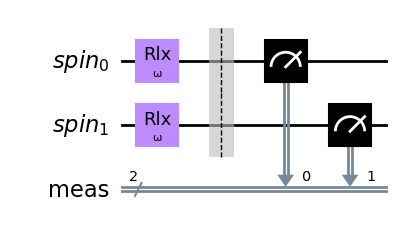

In [2]:
Nwires = 2
backend = SpinSimulator()
qc_rabi = QuantumCircuit(QuantumRegister(Nwires, "spin"))

all_modes=range(Nwires)
omega_t = Parameter("ω")

qc_rabi.rlx(omega_t, [0, 1])

qc_rabi.measure_all()
qc_rabi.draw(output='mpl')

In [3]:
phases = np.linspace(0, 2*np.pi, 15)

rabi_list = [
    qc_rabi.assign_parameters(
        {omega_t: phase},
        inplace=False,
    )
    for phase in phases
]

n_shots = 500
job_rabi = backend.run(rabi_list, shots=n_shots)
result_rabi = job_rabi.result()
counts_rabi = result_rabi.get_counts()

next we have to count the sum of the probabilities of both spins being in state 1, respectively.

In [4]:
sum_rabi = []
for i, _ in enumerate(phases):
    counts_up = 0
    for outcome, count in counts_rabi[i].items():
        if outcome[0] == "1":
            counts_up += count
        if outcome[-1] == "1":
            counts_up += count        
    sum_rabi.append(counts_up/n_shots)

Text(0, 0.5, 'sum of spins up')

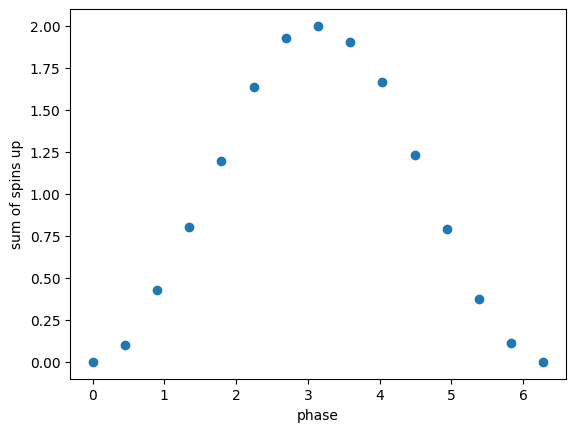

In [6]:
f, ax = plt.subplots()

ax.plot(phases, sum_rabi, 'o')
ax.set_xlabel('phase')
ax.set_ylabel('sum of spins up')

### Including the Blockade

Next, we implement the protocol which shows Rydberg blockade. This is done with the `rydberg_full` gate. It implements the already mentioned Hamiltonian time dynamics. 

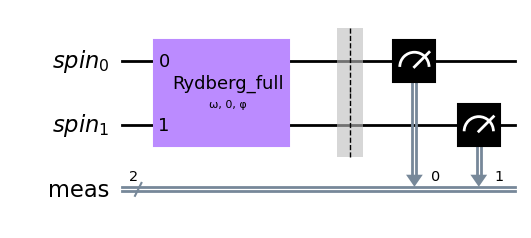

In [7]:
Nwires = 2
backend = SpinSimulator()
qc_block = QuantumCircuit(QuantumRegister(Nwires, "spin"))

all_modes=range(Nwires)
omega_t = Parameter("ω")
phi_t = Parameter("φ")

qc_block.rydberg_full(omega=omega_t, delta=0, phi=phi_t, modes=all_modes)

qc_block.measure_all()
qc_block.draw(output='mpl')

To simulate the blockade, we have to set the interaction strength $\phi$ to a value that is larger than the Rabi frequency $\Omega$. This is done by setting the `interaction_strength` parameter of the `rydberg_full` gate to a value much larger than 1.

In [8]:
phases = np.linspace(0, 2*np.pi, 15)

block_list = [
    qc_block.assign_parameters(
        {omega_t: phase, phi_t: phase*10},
        inplace=False,
    )
    for phase in phases
]

job_block = backend.run(block_list, shots=n_shots)
result_block = job_block.result()
counts_block = job_block.result().get_counts()

In [9]:
sum_block = []
for i, _ in enumerate(phases):
    counts_up = 0
    for outcome, count in counts_block[i].items():
        if outcome[0] == "1":
            counts_up += count
        if outcome[-1] == "1":
            counts_up += count        
    sum_block.append(counts_up/n_shots)

Now we can compare the dynamics without Rydberg blockade and with Rydberg blockade.

Text(0, 0.5, 'sum of spins up')

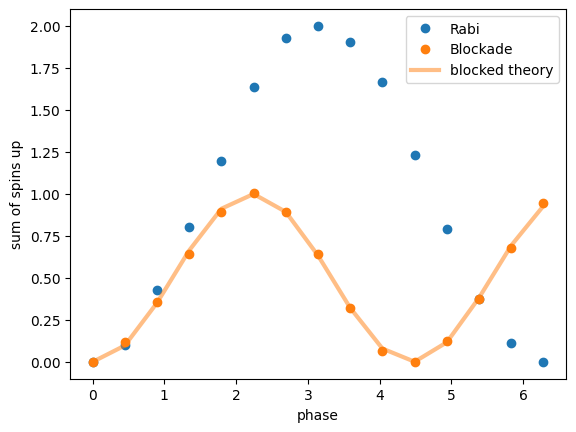

In [10]:
f, ax = plt.subplots()

ax.plot(phases, sum_rabi, 'o', label= 'Rabi')
ax.plot(phases, sum_block, 'o', label= 'Blockade')
ax.plot(phases, (1-np.cos(np.sqrt(2)*phases))/2, '-', color = "C1", alpha = 0.5, linewidth = 3, label= 'blocked theory')
ax.legend()
ax.set_xlabel('phase')
ax.set_ylabel('sum of spins up')

We can observe two things:

- The blockade almost completely suppressed the existence of both spins being up at the same time. This is due to its energetic cost.
- The oscillation frequency is increased by a factor of $\sqrt{2}$. This is an indication of the coherent, entangled dynamics, which are discussed in detail in the original paper.

### Controlled entanglement

Let us now also visualized in a single circuit how the rydberg Blockade might be used to generate an entangled state. For this we will employ the gate `rydberg_block`, which generates the blockade.

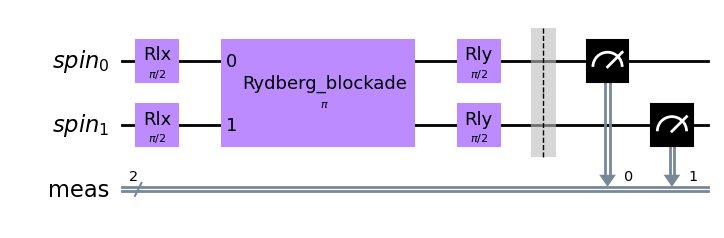

In [11]:
Nwires = 2
backend = SpinSimulator()
qc_entangle = QuantumCircuit(QuantumRegister(Nwires, "spin"))

all_modes=range(Nwires)

qc_entangle.rlx(np.pi/2, all_modes)
qc_entangle.rydberg_block(np.pi, modes=all_modes)
qc_entangle.rly(np.pi/2, 0)
qc_entangle.rly(np.pi/2, 1)
qc_entangle.measure_all()
qc_entangle.draw(output='mpl')

In [12]:
job_entangle = backend.run(qc_entangle, shots=500)
result_entangle = job_entangle.result()
print(result_entangle.get_counts())

{'1 1': 260, '0 0': 240}


As we can see the resulting state is an entangled Bell state, just as we envisionned.

## Spin structures from Rydberg interactions

In this section we will reproduce some parts of the results of the paper by [Bernien et al.](https://arxiv.org/abs/1707.04344), which demonstrates larger spin structures that arise dynamically. We will do this first based on the local spin simulator and then demonstrate how it works in a remote system.

Let us start out once more with the reference without Rydberg blockade

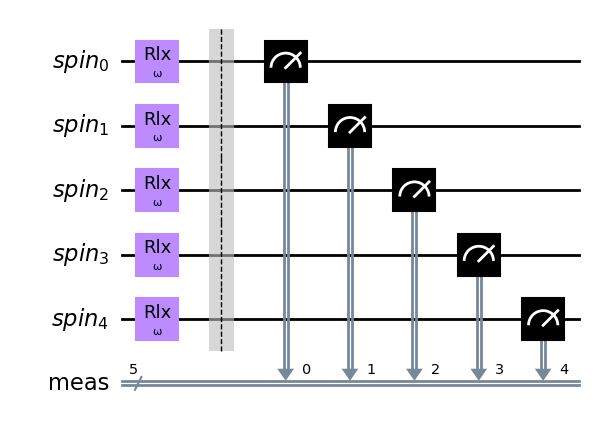

In [13]:
Nwires = 5
backend = SpinSimulator()
qc_rabi = QuantumCircuit(QuantumRegister(Nwires, "spin"))

all_modes=range(Nwires)
omega_t = Parameter("ω")

qc_rabi.rlx(omega_t, all_modes)

qc_rabi.measure_all()
qc_rabi.draw(output='mpl')

In [14]:
phases = np.linspace(0, 2*np.pi, 15)

rabi_list = [
    qc_rabi.assign_parameters(
        {omega_t: phase},
        inplace=False,
    )
    for phase in phases
]

job_rabi = backend.run(rabi_list, shots=500)
result_rabi = job_rabi.result()

outcomes_rabi = [result_rabi.get_memory(i) for i in range(len(rabi_list))]
for i, outcome in enumerate(outcomes_rabi):
    for j, run in enumerate(outcome):
        outcomes_rabi[i][j] = np.array(run.split(' '), dtype = int)
outcomes_rabi = np.array(outcomes_rabi)

Text(0.5, 0, 'time')

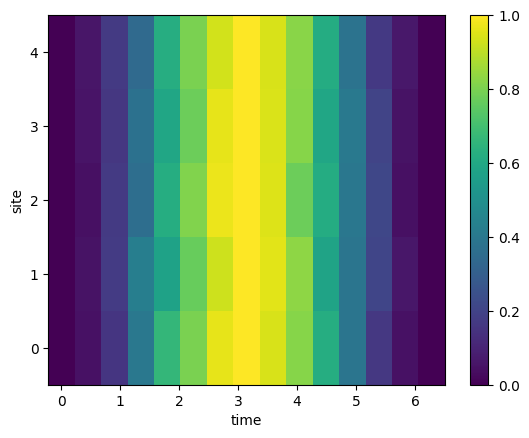

In [15]:
means_rabi = outcomes_rabi.mean(axis=1)

f, ax = plt.subplots()
im = ax.pcolormesh(phases, np.arange(Nwires), means_rabi.T)
f.colorbar(im, ax=ax)
ax.set_ylabel('site')
ax.set_xlabel('time')

We can see the all sites oscillate accordingly. So let us now implement the Blockade and observe its effect on the arising spin structures

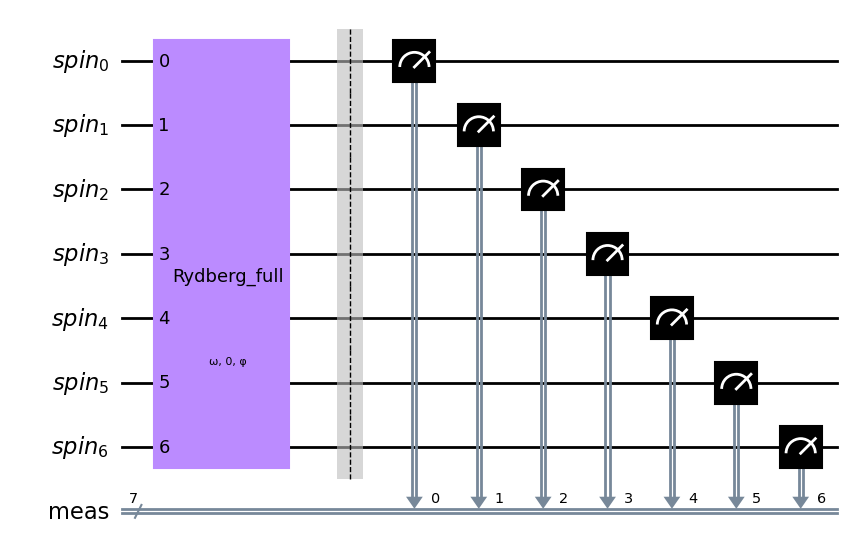

In [16]:
Nwires = 7
backend = SpinSimulator()
qc_block = QuantumCircuit(QuantumRegister(Nwires, "spin"))

all_modes=range(Nwires)
omega_t = Parameter("ω")
phi_t = Parameter("φ")

qc_block.rydberg_full(omega=omega_t, delta=0, phi=phi_t, modes=all_modes)

qc_block.measure_all()
qc_block.draw(output='mpl')

In [17]:
phases = np.linspace(0, 2*np.pi, 15)

block_list = [
    qc_block.assign_parameters(
        {omega_t: phase, phi_t: phase*5},
        inplace=False,
    )
    for phase in phases
]

job_block = backend.run(block_list, shots=500)
result_block = job_block.result()

In [18]:
outcomes = [result_block.get_memory(i) for i in range(len(block_list))]
for i, outcome in enumerate(outcomes):
    for j, run in enumerate(outcome):
        outcomes[i][j] = np.array(run.split(' '), dtype = int)
outcomes = np.array(outcomes)

means_block = outcomes.mean(axis=1)

Text(0.5, 0, 'time')

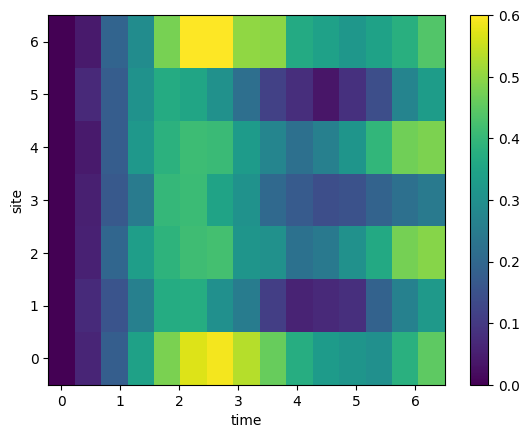

In [19]:
f, ax = plt.subplots()
im = ax.pcolormesh(phases, np.arange(Nwires), means_block.T)
f.colorbar(im, ax=ax)
ax.set_ylabel('site')
ax.set_xlabel('time')

The interactions now substantially altered the dynamics:

- On the outer sites that first oscillation appears quicker, which is reminiscent of the blockade scenario with two qubits.
- On site 1 and 5 the dynamics are strongly suppressed due to the strong interaction with all the neighbors.
- An alternating spin structure appears dynamically.

## Summary

In this tutorial we have seen how to simulate the dynamics of Rydberg atoms in a quantum circuit. 

- In a first step, we have generated simple single qubit dynamics from the Hamiltonian. 
- In a second step, we have demonstrated the Rydberg blockade and its effect on the dynamics. 
- Third, we have demonstrated how the blockade can be used to generate entanglement. 
Finally, we have demonstrated how the blockade can be used to generate spin structures more complex spin structures. 

This is a starting point for the simulation of more complex spin structures, which are the basis for the simulation of [quantum magnetism](https://arxiv.org/abs/2012.12268) or the design of quantum simulators for certain [optimization problems](https://arxiv.org/abs/2202.09372).

## Optional: Working on a cloud simulator

We would also like to send such circuits to some cloud services and investigate these results. In this last section, we will present this possibility with the [alqor](https://qlued.alqor.io) provider. 

<div class="alert alert-block alert-info">
<b>Note:</b> To run the cells in this part of the tutorial that interface with a remote device backend, you'll need to have a registered account with a valid username and token for this provider. You can obtain such credentials by visiting the <a href ='https://qlued.alqor.io/accounts/login/'>sign-up page</a></div>

In [20]:
from qiskit_cold_atom.providers import ColdAtomProvider
from pprint import pprint

Saving/enabling your backend credentials (Optional if not alreayd done).

In [21]:
#provider = ColdAtomProvider.save_account(
#    url=[
#        "https://qlued.alqor.io/api/v2/singlequdit",
#        "https://qlued.alqor.io/api/v2/multiqudit",
#        "https://qlued.alqor.io/api/v2/fermions",
#        "https://qlued.alqor.io/api/v2/rydberg",
#    ],
#    username="name",
#    token="token",
#    overwrite=True
#)

We can now load the necessary backend

In [22]:
provider = ColdAtomProvider.load_account()

spin_device_backend = provider.get_backend("alqor_rydberg_simulator")
pprint(spin_device_backend.configuration().supported_instructions)

['rlx', 'rlz', 'rydberg_block', 'rydberg_full', 'barrier', 'measure']


As you can see from above the simulator backend does provide the necessary gate that we used previously. So we can now simply execute the circuits from above on the cloud hardware:

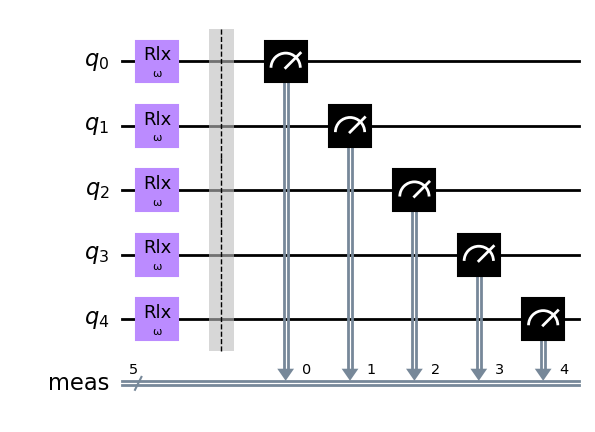

In [23]:
Nwires = 5

qc_rabi = QuantumCircuit(5)

all_modes=range(Nwires)
omega_t = Parameter("ω")

qc_rabi.rlx( omega_t, all_modes)

qc_rabi.measure_all()
qc_rabi.draw(output='mpl')

Now that we have created the circuit we can execute it in the same way as in the all the other tutorials.

In [24]:
phases = np.linspace(0, 2*np.pi,15)

remote_rabi_list = [
    qc_rabi.assign_parameters(
        {omega_t: phase},
        inplace=False,
    )
    for phase in phases
]

job_remote_rabi = spin_device_backend.run(remote_rabi_list, shots=500)

In [25]:
job_remote_rabi.job_id()

'20230425_154845-rydberg-fretchen-0a59f'

In [26]:
job_rabi_retrieved = spin_device_backend.retrieve_job(job_id=job_remote_rabi.job_id())

print("job status: ", job_rabi_retrieved.status())

job status:  JobStatus.DONE


In [27]:
result_remote_rabi = job_rabi_retrieved.result()

In [28]:
outcomes = [result_remote_rabi.get_memory(i) for i in range(len(remote_rabi_list))]
for i, outcome in enumerate(outcomes):
    for j, run in enumerate(outcome):
        outcomes[i][j] = np.array(run.split(' '), dtype = int)
        
outcomes = np.array(outcomes)
means_remote_rabi = outcomes.mean(axis=1)

Text(0.5, 0, 'time')

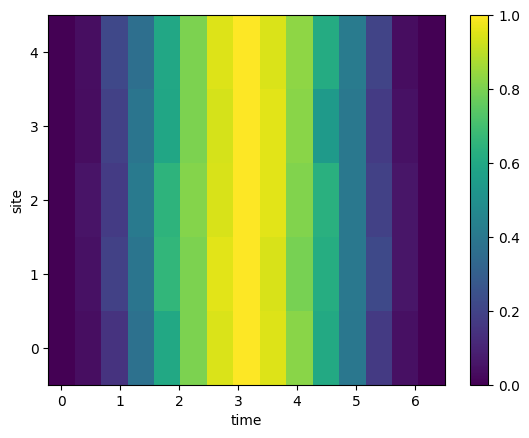

In [29]:
f, ax = plt.subplots()
im = ax.pcolormesh(phases,np.arange(5), means_remote_rabi.T)
f.colorbar(im, ax=ax)

ax.set_ylabel('site')
ax.set_xlabel('time')

### Blockade on a remote system

In this last step, we can execute the Ryber blockade on the remote system to observe the appearance of the alternating spin structure.

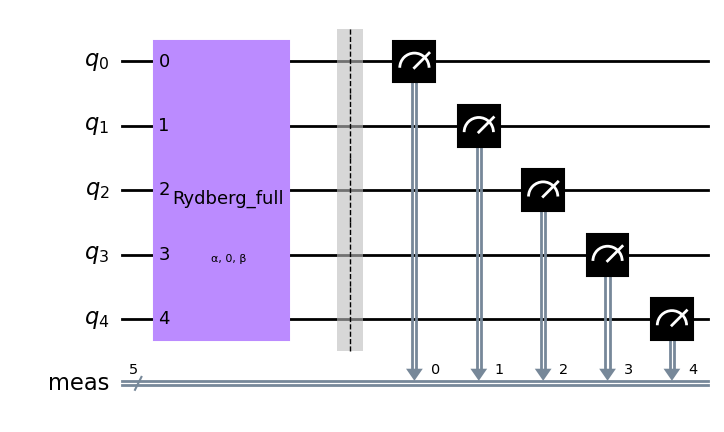

In [30]:
Nwires = 5
qc2 = QuantumCircuit(5)

all_modes=range(Nwires)
alpha = Parameter("α")
beta = Parameter("β")

qc2.rydberg_full(omega = alpha, delta =0, phi = beta, modes=all_modes)

qc2.measure_all()
qc2.draw(output='mpl')

In [31]:
phases = np.linspace(0, 2*np.pi,15)

circuit2_list = [
    qc2.assign_parameters(
        {alpha: phase, beta: phase*2},
        inplace=False,
    )
    for phase in phases
]

In [32]:
job2 = spin_device_backend.run(circuit2_list, shots=500)

In [33]:
job2.job_id()

'20230425_154935-rydberg-fretchen-78a2c'

In [34]:
job_retrieved2 = spin_device_backend.retrieve_job(job_id=job2.job_id())

print("job status: ", job_retrieved2.status())

job status:  JobStatus.DONE


In [35]:
result2 = job_retrieved2.result()

make this a card of averages

In [36]:
outcomes = [result2.get_memory(i) for i in range(len(circuit2_list))]
for i, outcome in enumerate(outcomes):
    for j, run in enumerate(outcome):
        outcomes[i][j] = np.array(run.split(' '), dtype = int)
outcomes = np.array(outcomes)

In [37]:
means_1 = outcomes.mean(axis=1)
means_1.shape

(15, 5)

Text(0.5, 0, 'time')

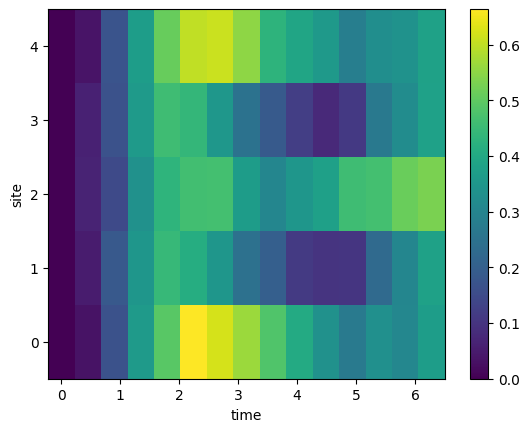

In [38]:
f, ax = plt.subplots()
im = ax.pcolormesh(phases,np.arange(5), means_1.T)
f.colorbar(im, ax=ax)

ax.set_ylabel('site')
ax.set_xlabel('time')

In [39]:
import qiskit.tools.jupyter

%qiskit_version_table